# Logistic Regression on European Weather Data from [Kaggle](https://www.kaggle.com/datasets/orvile/european-cities-weather-prediction-dataset/data)

## Table of Contents

- [Introduction](#Introduction)
- [Reshaping the DataFrame + Some Exploratory Data Analysis](#Reshaping-the-DataFrame-+-Some-Exploratory-Data-Analysis)
- [Preprocessing](#Preprocessing)
- [Training a Logistic Regression Model](#Training-a-Logistic-Regression-Model)
- [Evaluating the Model and Making Predictions](#Evaluating-the-Model-and-Making-Predictions)
- [Saving the Trained Model](#Saving-the-Trained-Model)
- [Conclusion](#Conclusion)

## Introduction

In this project, we explore a weather dataset covering 18 European cities from 2000-2010 to build a predictive model that determines whether it will rain tomorrow or not. This is a binary classification task, where the target variable is rain_tomorrow, indicating the presence (1) or absence (0) of rainfall on the following day.

We will approach the problem using Logistic Regression, a simple yet effective machine learning algorithm for binary classification. The goal is to leverage historical weather data — such as temperature, humidity, pressure, and cloud cover — to make accurate predictions about future rainfall events. Accurate forecasts of rain can be crucial for agriculture, travel planning, and various day-to-day decisions.

This notebook walks through the entire process from data loading and exploration, to preprocessing, training, evaluation, and finally, saving the model for future use.

## Reshaping the DataFrame + Some Exploratory Data Analysis

### Loading Packages and Data

In [1]:
# Load necessary packages
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression # train a logistic regression model
from sklearn.linear_model import SGDRegressor # train a model using the Stochastic Gradient Descent (SGD) technique
from sklearn.model_selection import train_test_split # to split data in train and test data 
from sklearn import preprocessing # imports preprocessing tools like One-Hot Encoding, used for handling categorical data.
from sklearn.preprocessing import StandardScaler # scale (or standardize) the values in numeric column
from sklearn.impute import SimpleImputer # replace missing values in a column
from sklearn.preprocessing import MinMaxScaler # scale data to a (0,1) range
from sklearn.metrics import accuracy_score # test the accuracy of the model's predictions
from sklearn.metrics import confusion_matrix # visualize the breakdown of correctly and incorrectly classified inputs using a confusion matrix

import joblib # for saving and loading Python objects like the machine learning model

# Load the weather dataset
file_path= 'data//weather_prediction_dataset.csv'

df = pd.read_csv(file_path)

# Convert the DATE column to datetime type
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

# Sort the DataFrame by the 'DATE' column
df = df.sort_values(by='DATE')

# print descriptive statistics of the dataset
print('Descriptive statistics for the dataset:')
print(df.describe())

Descriptive statistics for the dataset:
                      DATE        MONTH  BASEL_cloud_cover  BASEL_humidity  \
count                 3654  3654.000000        3654.000000     3654.000000   
mean   2004-12-31 12:00:00     6.520799           5.418446        0.745107   
min    2000-01-01 00:00:00     1.000000           0.000000        0.380000   
25%    2002-07-02 06:00:00     4.000000           4.000000        0.670000   
50%    2004-12-31 12:00:00     7.000000           6.000000        0.760000   
75%    2007-07-02 18:00:00    10.000000           7.000000        0.830000   
max    2010-01-01 00:00:00    12.000000           8.000000        0.980000   
std                    NaN     3.450083           2.325497        0.107788   

       BASEL_pressure  BASEL_global_radiation  BASEL_precipitation  \
count     3654.000000             3654.000000          3654.000000   
mean         1.017876                1.330380             0.234849   
min          0.985600                0.050000  

### Reshaping the DataFrame

The dataset initially comes in a **wide format**, where each weather variable for each city is represented as its own column—for example, `BASEL_cloud_cover`, `BUDAPEST_temp_mean`, `DRESDEN_precipitation`, and so on. This structure makes it difficult to analyze or model data across locations in a unified way.

To address this, the DataFrame is reshaped into a **long format**, where each row represents the weather data for a single location on a specific date. Here's how the transformation works:

- The city name is extracted from each column and stored in a new column called `LOCATION`.
- The weather variables (`cloud_cover`, `humidity`, `pressure`, `global_radiation`, `precipitation`, `sunshine`, `temp_mean`, `temp_min`, `temp_max`) are standardized into their own columns.
- The original `DATE` and `MONTH` columns are retained, and the new `LOCATION` column is placed just after `MONTH`.

In [2]:
# Step 1: desired weather features
features = ['cloud_cover', 'humidity', 'pressure', 'global_radiation', 'precipitation',
            'sunshine', 'temp_mean', 'temp_min', 'temp_max']

# Step 2: list of cities
locations = ['BASEL', 'BUDAPEST', 'DE_BILT', 'DRESDEN', 'DUSSELDORF', 'HEATHROW', 'KASSEL',
             'LJUBLJANA', 'MAASTRICHT', 'MALMO', 'MONTELIMAR', 'MUENCHEN', 'OSLO',
             'PERPIGNAN', 'SONNBLICK', 'STOCKHOLM', 'TOURS']

# Step 3: gather all valid city sub-dataframes
long_format_rows = []

for loc in locations:
    # Check which features exist for this location
    valid_features = [f for f in features if f"{loc}_{f}" in df.columns]
    loc_columns = {f"{loc}_{f}": f for f in valid_features}

    if not loc_columns:
        continue  # skip this location if no valid features

    # Build the temporary dataframe
    temp_df = df[['DATE', 'MONTH'] + list(loc_columns.keys())].copy()
    temp_df.rename(columns=loc_columns, inplace=True)
    temp_df['LOCATION'] = loc

    # Add rain_today
    temp_df = temp_df.dropna(subset=['precipitation'])
    temp_df['rain_today'] = (temp_df['precipitation'] > 0).astype(int)

    # Sort by date just in case
    temp_df = temp_df.sort_values('DATE')

    # Add rain_tomorrow by shifting
    temp_df['rain_tomorrow'] = temp_df['rain_today'].shift(-1)

    # Final column order
    temp_df = temp_df[['DATE', 'MONTH', 'LOCATION', 'rain_today', 'rain_tomorrow'] + list(loc_columns.values())]

    long_format_rows.append(temp_df)

# Step 4: Concatenate all into one long dataframe
weather = pd.concat(long_format_rows, ignore_index=True)

weather.dropna(subset=['rain_tomorrow'], inplace=True)
weather = weather.drop(weather[weather['cloud_cover'] < 0].index)
weather = weather.drop(weather[weather['sunshine'] < 0].index)
weather = weather.drop(weather[weather['pressure'] < 0].index)

print(weather.info())

<class 'pandas.core.frame.DataFrame'>
Index: 62067 entries, 0 to 62116
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              62067 non-null  datetime64[ns]
 1   MONTH             62067 non-null  int64         
 2   LOCATION          62067 non-null  object        
 3   rain_today        62067 non-null  int32         
 4   rain_tomorrow     62067 non-null  float64       
 5   cloud_cover       43802 non-null  float64       
 6   humidity          54795 non-null  float64       
 7   pressure          51108 non-null  float64       
 8   global_radiation  54795 non-null  float64       
 9   precipitation     62067 non-null  float64       
 10  sunshine          47455 non-null  float64       
 11  temp_mean         62067 non-null  float64       
 12  temp_min          58414 non-null  float64       
 13  temp_max          62067 non-null  float64       
dtypes: datetime64[ns](1), float

### Exploratory Data Analysis

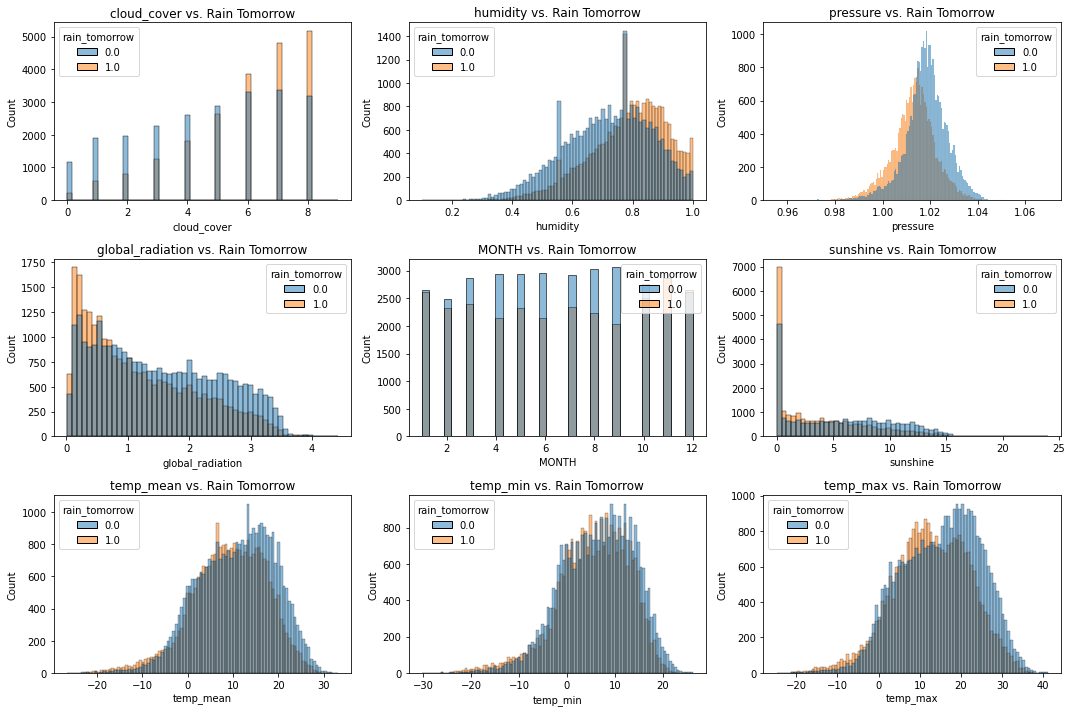

In [3]:
# Visualize the distribution of a few weather variables using histograms
columns = ['cloud_cover', 'humidity', 'pressure', 'global_radiation', 
                'MONTH', 'sunshine', 'temp_mean', 'temp_min', 'temp_max']

plt.figure(figsize=(15, 10))
for idx, col in enumerate(columns):
    plt.subplot(3, 3, idx+1)
    sns.histplot(data=weather, x=col, kde=False, hue='rain_tomorrow')
    if col == 'pressure':
        plt.xlim(0.95, 1.075)
    plt.title(f'{col} vs. Rain Tomorrow')
plt.tight_layout()
plt.show()

From these histograms, we can start to observe relationships between certain weather variables and the likelihood of rain the next day. For instance, higher atmospheric pressure appears to be associated with a lower chance of rain tomorrow, while lower pressure often coincides with rainy conditions. Additionally, the summer months show a greater tendency for rain, suggesting seasonal patterns in precipitation. Interestingly, higher maximum temperatures also seem to increase the probability of rain the following day.

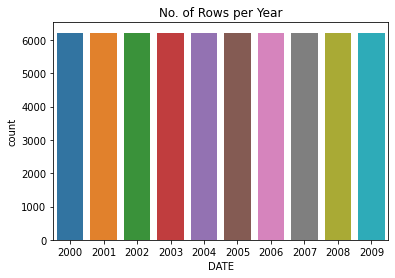

In [4]:
plt.title('No. of Rows per Year')
sns.countplot(x=weather["DATE"].dt.year);

## Preprocessing

### Splitting the Data into a Train- a Validation- and a Test-Set
Since we are working with dates we will separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

In [5]:
# Extract the year from the 'DATE' column
weather['year'] = weather['DATE'].dt.year

# Create the train, validation, and test datasets based on the year
train_df = weather[weather['year'] < 2006]
val_df = weather[(weather['year'] >= 2006) & (weather['year'] < 2008)]
test_df = weather[weather['year'] >= 2008]

# Drop the 'year' column if it's no longer needed
train_df = train_df.drop(columns=['year'])
val_df = val_df.drop(columns=['year'])
test_df = test_df.drop(columns=['year'])

# print descriptive statistics of the training dataset
print('Descriptive statistics for the training dataset:')
train_df.describe()

Descriptive statistics for the training dataset:


,DATE,MONTH,rain_today,rain_tomorrow,cloud_cover,humidity,pressure,global_radiation,precipitation,sunshine,temp_mean,temp_min,temp_max
count,37240,37240.000000,37240.00000,37240.000000,26280.000000,32880.000000,30664.000000,32880.000000,37240.000000,28472.000000,37240.000000,35048.000000,37240.000000
mean,2002-12-31 13:12:06.960257664,6.522503,0.46007,0.460150,5.290297,0.751252,1.016099,1.349449,0.230425,4.840464,9.965467,5.966877,14.011595
min,2000-01-01 00:00:00,1.000000,0.00000,0.000000,0.000000,0.180000,0.959000,0.010000,0.000000,0.000000,-26.600000,-30.300000,-24.700000
25%,2001-07-02 00:00:00,4.000000,0.00000,0.000000,4.000000,0.660000,1.011100,0.510000,0.000000,0.500000,4.100000,0.900000,7.200000
50%,2002-12-31 12:00:00,7.000000,0.00000,0.000000,6.000000,0.770000,1.016500,1.150000,0.000000,4.000000,10.500000,6.600000,14.400000
75%,2004-07-02 00:00:00,10.000000,1.00000,1.000000,7.000000,0.860000,1.021700,2.090000,0.200000,8.200000,16.200000,11.700000,21.100000
max,2005-12-31 00:00:00,12.000000,1.00000,1.000000,9.000000,1.000000,1.051200,4.420000,16.040000,17.800000,31.800000,26.100000,41.100000
std,NaN,3.448840,0.49841,0.498416,2.268183,0.140640,0.009124,0.957606,0.578466,4.389168,8.398075,7.583113,9.559829


### Identifying Input and Target Columns

In [6]:
# define the rain_tomorrow column as the target column and all others as inputs
input_cols = [col for col in train_df.columns if col != 'rain_tomorrow']
target_col = 'rain_tomorrow'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

# differentiate between numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Move 'rain_today' and 'MONTH' from numeric to categorical if present
for col in ['rain_today', 'MONTH']:
    if col in numeric_cols:
        numeric_cols.remove(col)
        categorical_cols.append(col)

train_inputs[numeric_cols].describe()

,cloud_cover,humidity,pressure,global_radiation,precipitation,sunshine,temp_mean,temp_min,temp_max
count,26280.000000,32880.000000,30664.000000,32880.000000,37240.000000,28472.000000,37240.000000,35048.000000,37240.000000
mean,5.290297,0.751252,1.016099,1.349449,0.230425,4.840464,9.965467,5.966877,14.011595
std,2.268183,0.140640,0.009124,0.957606,0.578466,4.389168,8.398075,7.583113,9.559829
min,0.000000,0.180000,0.959000,0.010000,0.000000,0.000000,-26.600000,-30.300000,-24.700000
25%,4.000000,0.660000,1.011100,0.510000,0.000000,0.500000,4.100000,0.900000,7.200000
50%,6.000000,0.770000,1.016500,1.150000,0.000000,4.000000,10.500000,6.600000,14.400000
75%,7.000000,0.860000,1.021700,2.090000,0.200000,8.200000,16.200000,11.700000,21.100000
max,9.000000,1.000000,1.051200,4.420000,16.040000,17.800000,31.800000,26.100000,41.100000


### Imputing Missing Numeric Data

In [7]:
print("summary count of missing (NaN) values in each numeric column of the weather DataFrame: ")
print(weather[numeric_cols].isna().sum())

summary count of missing (NaN) values in each numeric column of the weather DataFrame: 
cloud_cover         18265
humidity             7272
pressure            10959
global_radiation     7272
precipitation           0
sunshine            14612
temp_mean               0
temp_min             3653
temp_max                0
dtype: int64


In [8]:
# Fill in missing values in numeric columns using the mean of each column (computed from the full dataset)
imputer = SimpleImputer(strategy = 'mean')
imputer.fit(weather[numeric_cols])
#print(list(imputer.statistics_))

# Apply the fitted imputer to fill missing values in the training, validation, and test sets
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

print(test_inputs[numeric_cols].isna().sum())

cloud_cover         0
humidity            0
pressure            0
global_radiation    0
precipitation       0
sunshine            0
temp_mean           0
temp_min            0
temp_max            0
dtype: int64


### Scaling Numeric Features

In [9]:
# fit the scaler to the data i.e. compute the range of values for each numeric column
scaler = MinMaxScaler()
scaler.fit(weather[numeric_cols])

print('Minimum:')
print(list(scaler.data_min_))
print('Maximum:')
print(list(scaler.data_max_))

Minimum:
[0.0, 0.1, 0.0003, 0.01, 0.0, 0.0, -26.6, -30.3, -24.7]
Maximum:
[9.0, 1.0, 1.0512, 4.42, 16.04, 24.0, 33.1, 26.3, 41.1]


In [10]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

train_inputs[numeric_cols].describe()

,cloud_cover,humidity,pressure,global_radiation,precipitation,sunshine,temp_mean,temp_min,temp_max
count,37240.000000,37240.000000,37240.000000,37240.000000,37240.000000,37240.000000,37240.000000,37240.000000,37240.000000
mean,0.587262,0.723501,0.966567,0.303809,0.014366,0.201780,0.612487,0.640824,0.588322
std,0.211711,0.146834,0.007879,0.204037,0.036064,0.159909,0.140671,0.129975,0.145286
min,0.000000,0.088889,0.912266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.555556,0.633333,0.963174,0.129252,0.000000,0.058333,0.514238,0.558304,0.484802
50%,0.585945,0.722656,0.966420,0.304408,0.000000,0.202085,0.621441,0.641892,0.594225
75%,0.777778,0.833333,0.970692,0.442177,0.012469,0.287500,0.716918,0.736749,0.696049
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.741667,0.978224,0.996466,1.000000


### Encoding Categorical Data

In [11]:
weather[categorical_cols].nunique()

LOCATION      17
rain_today     2
MONTH         12
dtype: int64

In [12]:
# initialize a OneHotEncoder
encoder = preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore')
# fit the encoder to the data i.e. identify the full list of categories across all categorical columns
encoder.fit(weather[categorical_cols])
# generate column names for each individual category using get_feature_names
encoded_cols = list(encoder.get_feature_names(categorical_cols))
print(encoded_cols)

['LOCATION_BASEL', 'LOCATION_BUDAPEST', 'LOCATION_DE_BILT', 'LOCATION_DRESDEN', 'LOCATION_DUSSELDORF', 'LOCATION_HEATHROW', 'LOCATION_KASSEL', 'LOCATION_LJUBLJANA', 'LOCATION_MAASTRICHT', 'LOCATION_MALMO', 'LOCATION_MONTELIMAR', 'LOCATION_MUENCHEN', 'LOCATION_OSLO', 'LOCATION_PERPIGNAN', 'LOCATION_SONNBLICK', 'LOCATION_STOCKHOLM', 'LOCATION_TOURS', 'rain_today_0', 'rain_today_1', 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12']


In [13]:
# perform the encoding, we use the transform method of encoder
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

pd.set_option('display.max_columns', None)

print(train_inputs.head())

        DATE  MONTH LOCATION  rain_today  cloud_cover  humidity  pressure  \
0 2000-01-01      1    BASEL           1     0.888889  0.877778  0.978495   
1 2000-01-02      1    BASEL           0     0.888889  0.855556  0.981540   
2 2000-01-03      1    BASEL           0     0.555556  0.788889  0.981159   
3 2000-01-04      1    BASEL           1     0.777778  0.766667  0.976211   
4 2000-01-05      1    BASEL           1     0.555556  0.888889  0.974688   

   global_radiation  precipitation  sunshine  temp_mean  temp_min  temp_max  \
0          0.043084       0.001870  0.000000   0.494137  0.563604  0.434650   
1          0.054422       0.000000  0.000000   0.505863  0.583039  0.448328   
2          0.111111       0.000000  0.154167   0.482412  0.537102  0.448328   
3          0.140590       0.021820  0.287500   0.510888  0.544170  0.489362   
4          0.113379       0.004364  0.154167   0.546064  0.602473  0.506079   

   LOCATION_BASEL  LOCATION_BUDAPEST  LOCATION_DE_BILT  LOCATI

### Saving Processed Data to Disk

In [14]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (37240, 44)
train_targets: (37240,)
val_inputs: (12402, 44)
val_targets: (12402,)
test_inputs: (12425, 44)
test_targets: (12425,)


In [15]:
# save inputs as parquet
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')
# convert targets into DataFrames and save them as parquet
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

In [16]:
# read the data back using pd.read_parquet()

train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')

train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]

print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (37240, 44)
train_targets: (37240,)
val_inputs: (12402, 44)
val_targets: (12402,)
test_inputs: (12425, 44)
test_targets: (12425,)


## Training a Logistic Regression Model

In [17]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets) # train_inputs still contains categorical columns, we do not want to add them to the model

LogisticRegression(class_weight='balanced', solver='liblinear')

In [18]:
#check the weights and biases of the trained model
weights = pd.DataFrame({
    'feature': (numeric_cols + encoded_cols + ['intercept']),
    'weight': model.coef_.tolist()[0] + model.intercept_.tolist()
})

print(weights)

                feature    weight
0           cloud_cover  1.119386
1              humidity  0.522415
2              pressure -9.595553
3      global_radiation  0.183236
4         precipitation  5.866358
5              sunshine  0.714978
6             temp_mean  2.098883
7              temp_min  0.062442
8              temp_max -1.046594
9        LOCATION_BASEL  0.280410
10    LOCATION_BUDAPEST -0.241166
11     LOCATION_DE_BILT  0.439416
12     LOCATION_DRESDEN  0.305685
13  LOCATION_DUSSELDORF  0.518195
14    LOCATION_HEATHROW  0.329447
15      LOCATION_KASSEL  0.594148
16   LOCATION_LJUBLJANA  0.081094
17  LOCATION_MAASTRICHT  0.400829
18       LOCATION_MALMO  0.105930
19  LOCATION_MONTELIMAR -0.257875
20    LOCATION_MUENCHEN  0.432245
21        LOCATION_OSLO  0.276748
22   LOCATION_PERPIGNAN -0.517126
23   LOCATION_SONNBLICK  1.058513
24   LOCATION_STOCKHOLM  0.240407
25       LOCATION_TOURS  0.379027
26         rain_today_0  1.693314
27         rain_today_1  2.732612
28            

Each weight is applied to the value in a specific column of the input. Higher the weight, greater the impact of the column on the prediction.

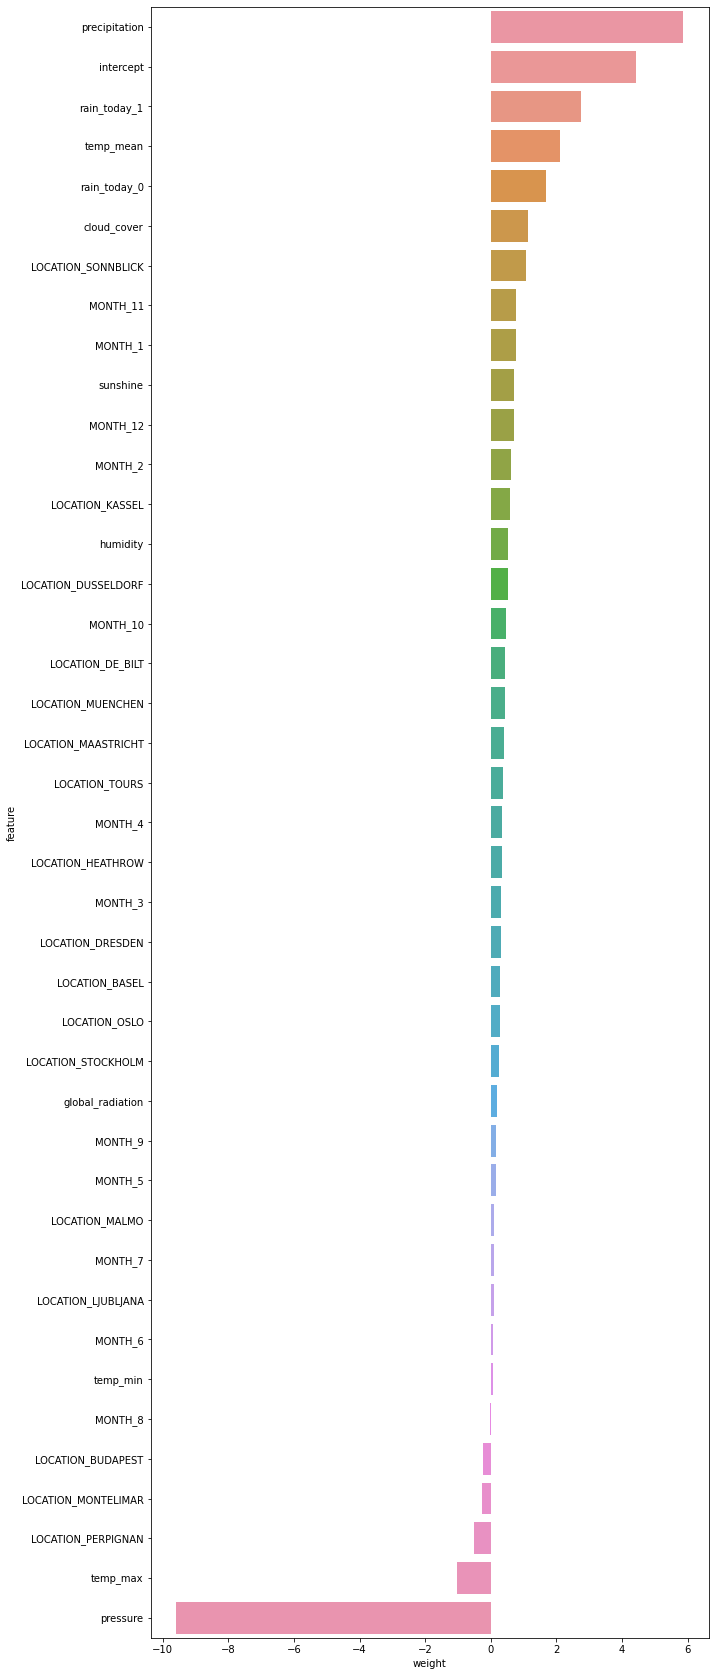

In [19]:
plt.figure(figsize=(10,30))
sns.barplot(data=weights.sort_values('weight', ascending=False), x='weight', y='feature');

## Evaluating the Model and Making Predictions

### Evaluating the Model

In [20]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# predictions for the three data sets
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# probabilities computed by the model for the three data sets
train_probs = model.predict_proba(X_train)
val_probs = model.predict_proba(X_val)
test_probs = model.predict_proba(X_test)

print(train_preds)
print(train_targets)

[1. 0. 0. ... 0. 1. 1.]
0        0.0
1        0.0
2        1.0
3        1.0
4        0.0
        ... 
60651    0.0
60652    0.0
60653    1.0
60654    1.0
60655    1.0
Name: rain_tomorrow, Length: 37240, dtype: float64


In [21]:
accuracy = accuracy_score(train_targets, train_preds)

print("The model predicts rain tomorrow with " + str(round((100*accuracy),2)) + " % accuracy.")

The model predicts rain tomorrow with 68.58 % accuracy.


In [34]:
confusion_matrix(train_targets, train_preds, normalize='true')

array([[0.71120175, 0.28879825],
       [0.34389589, 0.65610411]])

Accuracy: 68.58%


array([1., 0., 0., ..., 0., 1., 1.])

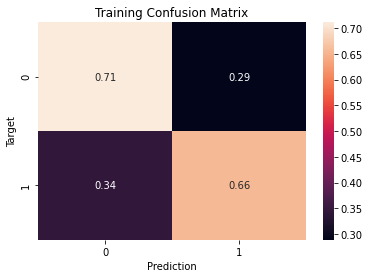

In [23]:
# define a helper function to generate predictions, 
# compute the accuracy score and plot a confusion matrix for a given set of inputs
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

# use predict_and_plot function for the training data
predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 69.71%


array([1., 0., 0., ..., 1., 0., 0.])

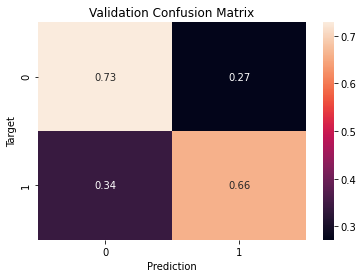

In [24]:
# use predict_and_plot function for the validation data
predict_and_plot(X_val, val_targets, 'Validation')

Accuracy: 67.78%


array([0., 0., 0., ..., 1., 1., 1.])

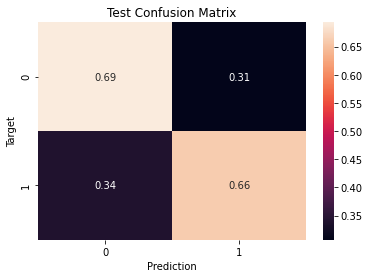

In [25]:
# use predict_and_plot function for the test data
predict_and_plot(X_test, test_targets, 'Test')

Let's create two models: one that guesses randomly and another that always returns "No". Both of these models completely ignore the inputs given to them. We then compare their results to the model above.

In [26]:
def random_guess(inputs):
    return np.random.choice([0, 1], len(inputs))

accuracy_score(test_targets, random_guess(X_test))

0.494728370221328

In [27]:
def all_no(inputs):
    return np.full(len(inputs), 0)

accuracy_score(test_targets, all_no(X_test))

0.5271629778672032

A random model performs at around 50% accuracy, as expected for a binary classification task. A naive model that always predicts "No" (i.e., no rain tomorrow) achieves a slightly higher accuracy of about 53% on the test dataset, due to class imbalance.

In comparison, the trained logistic regression model achieves an accuracy of 67.78%, demonstrating that it captures meaningful patterns in the data and performs noticeably better than both random and naive baselines.

### Making Predictions on a Single Input

In [28]:
# create a new input
new_input = {'MONTH': 2,
             'LOCATION': 'BUDAPEST',
             'rain_today': 0,
             'cloud_cover': 5,
             'humidity': 0.5,
             'pressure': 1.1,
             'global_radiation': np.nan,
             'precipitation': np.nan,
             'sunshine': 3,
             'temp_mean': 20,
             'temp_min': 13.0,
             'temp_max': 25.0,
             }

In [29]:
# define a helper function to make predictions for individual inputs
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

predict_input(new_input)

(0.0, 0.8284264428545524)

The model predicts that with a probability of 74.2% it will not rain in Budapest tomorrow.

## Saving the Trained Model

In [30]:
# create a dictionary containing all the required objects
europe_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

# save this to a file using joblib.dump
joblib.dump(europe_rain, 'europe_rain.joblib')

['europe_rain.joblib']

In [31]:
# load back the model using joblib.load
europe_rain2 = joblib.load('europe_rain.joblib')

test_preds2 = europe_rain2['model'].predict(X_test)
accuracy_score(test_targets, test_preds2)

0.6778269617706237

## Conclusion

In this project, we trained a logistic regression model to predict whether it will rain tomorrow based on historical weather data from various European cities. After extensive preprocessing—including reshaping the data, handling missing values, and encoding categorical variables—we evaluated the model on training, validation, and test datasets.

The model achieved an accuracy of **68.58%** on the test set, outperforming both a random classifier (50%) and a naive baseline that always predicts "no rain" (53%). This suggests that the model has learned meaningful relationships from the data.

The confusion matrices across the three datasets further support the model’s generalization ability:

- **Training:** 71.1% True Negatives, 65.6% True Positives  
- **Validation:** 72.8% True Negatives, 65.9% True Positives  
- **Test:** 69.3% True Negatives, 66.1% True Positives  

These results are fairly consistent, indicating that the model is **not overfitting**—it performs similarly well on unseen validation and test data. While there is still room for improvement, especially in reducing false positives, the current model offers a solid baseline for predicting rainfall using logistic regression.